In [1]:
#..modified by CHUYAN at Nov/05/2021; calculate binned P-E/SST/subsidence/ LTS and LWP/(TWP) array for Model: CNRM-ESM2-1; (annual-mean, binned 5X5 degree,
#.. area-mean data,) for pi-Control and abrupt4XCO2 experiment, then use the sensitivity of LWP to CCFs to get a Linear regression model to predict
#.. the LWP and d(LWP)/dGMT.. However, we wants to know why different SST zone will have diff efficiency in producing clouds with Warming..

import netCDF4
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import PyNIO as Nio
import pandas as pd

from scipy import stats
from sklearn import linear_model

from sklearn.metrics import mean_squared_error, r2_score
from read_hs_file import read_var_mod

from matplotlib.ticker import MaxNLocator
from matplotlib.colors import BoundaryNorm


In [2]:
x1 = [1,2,3,4,5]
x2 = [6,7,8,9,10]
x3 = [11,12,13,14]

data = []
data.append(x1)
data.append(x2)
data.append(x3)

print(np.array(data))



#T_700_alevs,times_pi = read_var_mod(modn='CNRM-ESM2-1', consort='CNRM-CERFACS', varnm='ta', cmip='cmip6', exper='piControl', ensmem='r1i1p1f2', typevar='Amon', gg='gr', read_p=True, time1=[1850, 1, 1], time2=[2349, 12, 31])[0],[4]

#..Total Water Path
fn_wvp_abr  = xr.open_dataset('/glade/collections/cmip/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1/abrupt-4xCO2/r1i1p1f2/Amon/prw/gr/v20181026/prw/prw_Amon_CNRM-ESM2-1_abrupt-4xCO2_r1i1p1f2_gr_185001-199912.nc')

prw_abr = np.array(fn_wvp_abr.variables['prw'])   #..Water Vapor Path , kg m-2 300yrs

fn_wvp_pi   = xr.open_dataset('/glade/collections/cmip/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1/piControl/r1i1p1f2/Amon/prw/gr/v20181115/prw/prw_Amon_CNRM-ESM2-1_piControl_r1i1p1f2_gr_185001-234912.nc')
prw_pi  = np.array(fn_wvp_pi.variables['prw'])   #..500 yrs

print(np.nanmean(prw_abr), np.nanmean(prw_pi), prw_pi.shape)

#fn_wvp_pi


[list([1, 2, 3, 4, 5]) list([6, 7, 8, 9, 10]) list([11, 12, 13, 14])]


/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/xarray/coding/times.py:463: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/xarray/coding/times.py:463: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=or

25.71918 17.449663 (6000, 128, 256)


In [2]:
#..netCDF4 for retrieving variables in 'pi' and 'abr': 

#..abrupt4xCO2
sfc_T_abr       = read_var_mod(modn='CNRM-ESM2-1', consort='CNRM-CERFACS', varnm='ts', cmip='cmip6', exper='abrupt-4xCO2', ensmem='r1i1p1f2', typevar='Amon', gg='gr', read_p=False, time1=[1850, 1, 1], time2=[1999, 12, 31])[0]

T_700_alevs_abr,P,lat_abr,lon_abr,times_abr = read_var_mod(modn='CNRM-ESM2-1', consort='CNRM-CERFACS', varnm='ta', cmip='cmip6', exper='abrupt-4xCO2', ensmem='r1i1p1f2', typevar='Amon', gg='gr', read_p=True, time1=[1850, 1, 1], time2=[1999, 12, 31])
T_700_abr = T_700_alevs_abr[:, 3,:,:]   #..700 hPa levels

sfc_P_abr       = read_var_mod(modn='CNRM-ESM2-1', consort='CNRM-CERFACS', varnm='ps', cmip='cmip6', exper='abrupt-4xCO2', ensmem='r1i1p1f2', typevar='Amon', gg='gr', read_p=False, time1=[1850, 1, 1], time2=[1999, 12, 31])[0]   

sub_abr         = read_var_mod(modn='CNRM-ESM2-1', consort='CNRM-CERFACS', varnm='wap', cmip='cmip6', exper='abrupt-4xCO2', ensmem='r1i1p1f2', typevar='Amon', gg='gr', read_p=True, time1=[1850, 1, 1], time2=[1999, 12, 31])[0][:, 5,:,:] 
#..500mb downward motions

clivi_abr       = read_var_mod(modn='CNRM-ESM2-1', consort='CNRM-CERFACS', varnm='clivi', cmip='cmip6', exper='abrupt-4xCO2', ensmem='r1i1p1f2', typevar='Amon', gg='gr', read_p=False, time1=[1850, 1, 1], time2=[1999, 12, 31])[0]
clwvi_abr       = read_var_mod(modn='CNRM-ESM2-1', consort='CNRM-CERFACS', varnm='clwvi', cmip='cmip6', exper='abrupt-4xCO2', ensmem='r1i1p1f2', typevar='Amon', gg='gr', read_p=False, time1=[1850, 1, 1], time2=[1999, 12, 31])[0]
tas_abr         = read_var_mod(modn='CNRM-ESM2-1', consort='CNRM-CERFACS', varnm='tas', cmip='cmip6', exper='abrupt-4xCO2', ensmem='r1i1p1f2', typevar='Amon', gg='gr', read_p=False, time1=[1850, 1, 1], time2=[1999, 12, 31])[0]

P_abr           = read_var_mod(modn='CNRM-ESM2-1', consort='CNRM-CERFACS', varnm='pr', cmip='cmip6', exper='abrupt-4xCO2', ensmem='r1i1p1f2', typevar='Amon', gg='gr', read_p=False, time1=[1850, 1, 1], time2=[1999, 12, 31])[0]

E_abr           = read_var_mod(modn='CNRM-ESM2-1', consort='CNRM-CERFACS', varnm='evspsbl', cmip='cmip6', exper='abrupt-4xCO2', ensmem='r1i1p1f2', typevar='Amon', gg='gr', read_p=False, time1=[1850, 1, 1], time2=[1999, 12, 31])[0]
print(sfc_T_abr.shape)
#..1800 months = 150 yrs for CNRM-ESM2-1:abrupt experiement



#..Total Water Path
fn_wvp_abr  = xr.open_dataset('/glade/collections/cmip/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1/abrupt-4xCO2/r1i1p1f2/Amon/prw/gr/v20181026/prw/prw_Amon_CNRM-ESM2-1_abrupt-4xCO2_r1i1p1f2_gr_185001-199912.nc')

prw_abr = np.array(fn_wvp_abr.variables['prw'])   #..Water Vapor Path , kg m-2 300yrs

fn_wvp_pi   = xr.open_dataset('/glade/collections/cmip/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1/piControl/r1i1p1f2/Amon/prw/gr/v20181115/prw/prw_Amon_CNRM-ESM2-1_piControl_r1i1p1f2_gr_185001-234912.nc')
prw_pi  = np.array(fn_wvp_pi.variables['prw'])   #..500 yrs
#print(np.nanmean(prw_abr), np.nanmean(prw_pi), prw_pi.shape)


#..pi-Control
sfc_T       = read_var_mod(modn='CNRM-ESM2-1', consort='CNRM-CERFACS', varnm='ts', cmip='cmip6', exper='piControl', ensmem='r1i1p1f2', typevar='Amon', gg='gr', read_p=False, time1=[1850, 1, 1], time2=[2349, 12, 31])[0]

T_700_alevs,times_pi = read_var_mod(modn='CNRM-ESM2-1', consort='CNRM-CERFACS', varnm='ta', cmip='cmip6', exper='piControl', ensmem='r1i1p1f2', typevar='Amon', gg='gr', read_p=True, time1=[1850, 1, 1], time2=[2349, 12, 31])[0],[4]
T_700       = T_700_alevs[:, 3,:,:]

sfc_P       = read_var_mod(modn='CNRM-ESM2-1', consort='CNRM-CERFACS', varnm='ps', cmip='cmip6', exper='piControl', ensmem='r1i1p1f2', typevar='Amon', gg='gr', read_p=False, time1=[1850, 1, 1], time2=[2349, 12, 31])[0]   
#..sea surface Pressure, Units in Pa

sub         = read_var_mod(modn='CNRM-ESM2-1', consort='CNRM-CERFACS', varnm='wap', cmip='cmip6', exper='piControl', ensmem='r1i1p1f2', typevar='Amon', gg='gr', read_p=True, time1=[1850, 1, 1], time2=[2349, 12, 31])[0][:, 5,:,:] 
#..500mb downward mot0001

clivi       = read_var_mod(modn='CNRM-ESM2-1', consort='CNRM-CERFACS', varnm='clivi', cmip='cmip6', exper='piControl', ensmem='r1i1p1f2', typevar='Amon', gg='gr', read_p=False, time1=[1850, 1, 1], time2=[2349, 12, 31])[0]
#..ICE WATER PATH, Units in kg m^-2
clwvi       = read_var_mod(modn='CNRM-ESM2-1', consort='CNRM-CERFACS', varnm='clwvi', cmip='cmip6', exper='piControl', ensmem='r1i1p1f2', typevar='Amon', gg='gr', read_p=False, time1=[1850, 1, 1], time2=[2349, 12, 31])[0]
tas         = read_var_mod(modn='CNRM-ESM2-1', consort='CNRM-CERFACS', varnm='tas', cmip='cmip6', exper='piControl', ensmem='r1i1p1f2', typevar='Amon', gg='gr', read_p=False, time1=[1850, 1, 1], time2=[2349, 12, 31])[0]
#..2-m air Temperature, for 'gmt'

P           = read_var_mod(modn='CNRM-ESM2-1', consort='CNRM-CERFACS', varnm='pr', cmip='cmip6', exper='piControl', ensmem='r1i1p1f2', typevar='Amon', gg='gr', read_p=False, time1=[1850, 1, 1], time2=[2349, 12, 31])[0]
#..Precipitation, Units in kg m^-2 s^-1 = mm *s^-1
E           = read_var_mod(modn='CNRM-ESM2-1', consort='CNRM-CERFACS', varnm='evspsbl', cmip='cmip6', exper='piControl', ensmem='r1i1p1f2', typevar='Amon', gg='gr', read_p=False, time1=[1850, 1, 1], time2=[2349, 12, 31])[0]
#..Evaporations, Units also in kg m^-2 s^-1 = mm *s^-1

print(sfc_T.shape)
#..6000 months = 500 yrs for CNRM-ESM2-1 piControl experiment


['/glade/collections/cmip//CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1/abrupt-4xCO2/r1i1p1f2/Amon/ts/gr/v20181026/ts/']
/glade/collections/cmip//CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1/abrupt-4xCO2/r1i1p1f2/Amon/ts/gr/v20181026/ts//*ts**_**nc*
/glade/collections/cmip//CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1/abrupt-4xCO2/r1i1p1f2/Amon/ts/gr/v20181026/ts/ts_Amon_CNRM-ESM2-1_abrupt-4xCO2_r1i1p1f2_gr_185001-199912.nc
(1800, 128, 256)
['/glade/collections/cmip//CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1/abrupt-4xCO2/r1i1p1f2/Amon/ta/gr/v20181026/ta/']
/glade/collections/cmip//CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1/abrupt-4xCO2/r1i1p1f2/Amon/ta/gr/v20181026/ta//*ta**_**nc*
/glade/collections/cmip//CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1/abrupt-4xCO2/r1i1p1f2/Amon/ta/gr/v20181026/ta/ta_Amon_CNRM-ESM2-1_abrupt-4xCO2_r1i1p1f2_gr_185001-199912.nc
(1800, 19, 128, 256)
['/glade/collections/cmip//CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1/abrupt-4xCO2/r1i1p1f2/Amon/ps/gr/v20181026/ps/']
/glade/collections/cmip//CMIP6/CMIP/CNRM-CERFACS

/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/xarray/coding/times.py:463: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/xarray/coding/times.py:463: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=or

['/glade/collections/cmip//CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1/piControl/r1i1p1f2/Amon/ts/gr/v20181115/ts/']
/glade/collections/cmip//CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1/piControl/r1i1p1f2/Amon/ts/gr/v20181115/ts//*ts**_**nc*
/glade/collections/cmip//CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1/piControl/r1i1p1f2/Amon/ts/gr/v20181115/ts/ts_Amon_CNRM-ESM2-1_piControl_r1i1p1f2_gr_185001-234912.nc
(6000, 128, 256)
['/glade/collections/cmip//CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1/piControl/r1i1p1f2/Amon/ta/gr/v20181115/ta/']
/glade/collections/cmip//CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1/piControl/r1i1p1f2/Amon/ta/gr/v20181115/ta//*ta**_**nc*
/glade/collections/cmip//CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1/piControl/r1i1p1f2/Amon/ta/gr/v20181115/ta/ta_Amon_CNRM-ESM2-1_piControl_r1i1p1f2_gr_185001-234912.nc
(6000, 19, 128, 256)
['/glade/collections/cmip//CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1/piControl/r1i1p1f2/Amon/ps/gr/v20181115/ps/']
/glade/collections/cmip//CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1/piControl/r1i1

In [3]:
#..choose lat 40 -85 °S as the Southern-Ocean Regions

lons        = lon_abr
lats        = lat_abr[:]

levels      = np.array(P)
times       = times_abr
#print(lats, lons)

lati0 = -40.
latsi0= min(range(len(lats)), key = lambda i: abs(lats[i] - lati0))
lati1 = -85.
latsi1= min(range(len(lats)), key = lambda i: abs(lats[i] - lati1))
print(latsi0, latsi1)


35 3


In [4]:
#..abrupt4xCO2
Precip_abr =  np.array(P_abr) * (24.*60.*60.)   #..Precipitation. Convert the units from kg m^-2 s^-1 -> mm*day^-1
print(np.nanmean(Precip_abr))   #.. IPSL/abr2.80..  CNRM ESM2 1/abr 2.69.. CESM2/abr 2.74..
Eva_abr    =  np.array(E_abr) * (24.*60.*60.)   #..evaporation, mm day^-1
print(np.nanmean(Eva_abr))         #.. IPSL/abr2.50..  CNRM ESM2 1/abr 2.43.. CESM2/abr 2.43..
print(Eva_abr.shape)

#..pi-Control
Precip =  np.array(P) * (24.*60.*60.)   #..Precipitation. Convert the units from kg m^-2 s^-1 -> mm*day^-1
print(np.nanmean(Precip))   #.. IPSL/piC 2.43..CNRM/piC 2.40.. CESM2/PIc 2.39
Eva    =  np.array(E) * (24.*60.*60.)   #..evaporation, mm day^-1
print(np.nanmean(Eva))   #.. IPSL/piC  2.21..CNRM/piC 2.20.. CESM2/PIc 2.17..
print(Eva.shape)



2.6877267
2.4250267
(1800, 128, 256)
2.4036179
2.2042403
(6000, 128, 256)


In [5]:
#..abrupt4xCO2 Variables: LWP, tas(gmt), SST, p-e, LTS, subsidence
LWP_abr  = np.array(clwvi_abr) - np.array(clivi_abr)   #..units in kg m^-2

gmt_abr  = np.array(tas_abr)

SST_abr  = np.array(sfc_T_abr)

MC_abr  = Precip_abr - Eva_abr   #..Moisture Convergence calculated from abrupt4xCO2's P - E, Units in mm day^-1

Twp_abr  = np.array(clwvi_abr)
Iwp_abr  = np.array(clivi_abr)


#..pi-Control Variables: LWP, tas(gmt), SST, p-e, LTS, subsidence
LWP  = np.array(clwvi) - np.array(clivi)   #..units in kg m^-2

gmt  = np.array(tas)

SST  = np.array(sfc_T)

MC  = Precip - Eva   #..Moisture Convergence calculated from pi-Control's P - E, Units in mm day^-1

Twp  = np.array(clwvi)
Iwp  = np.array(clivi)

In [6]:
#..abrupt4xCO2 Lower Tropospheric Stability
k  = 0.286
theta_700_abr  = np.array(T_700_abr)* (100000./70000.)**k

#print(theta_700_abr)

theta_skin_abr = np.array(sfc_T_abr)* (100000./np.array(sfc_P_abr))**k
LTS_m_abr  = theta_700_abr - theta_skin_abr

#..Subtract the outliers in T_700 and LTS_m, 'nan' comes from
LTS_e_abr  = np.ma.masked_where(theta_700_abr >= 500, LTS_m_abr)
#print(LTS_e_abr)

#..Subsidence, units in Pa s^-1 at 500 hPa:
Subsidence_abr =  np.array(sub_abr)


#..pi-Control Lower Tropospheric Stability

theta_700  = np.array(T_700)* (100000./70000.)**k

#print(theta_700)

theta_skin = np.array(sfc_T)* (100000./np.array(sfc_P))**k
LTS_m  = theta_700 - theta_skin

#..Subtract the outliers in T_700 and LTS_m, 'nan' comes from
LTS_e  = np.ma.masked_where(theta_700 >= 500, LTS_m)
#print(LTS_e, LTS_m)

#..Subsidence, units in Pa s^-1 at 500 hPa:
Subsidence =  np.array(sub)


In [7]:
indf= np.isnan(LTS_e_abr)==True
indf_false = np.nonzero(indf ==True)

print(indf_false)
print(np.array(indf_false).shape)

print(LTS_e_abr[11,7,14],LTS_m_abr[11,7,14], T_700_abr[11,7,14])



(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(3, 0)
9.903137 9.903137 256.08008


In [8]:
#..Convert variables becoming Annual-mean, Southern-Ocean region arrays

#..abrupt4xCO2
Tg_abr  = np.zeros((150,128,256))   #..Surface air Temperature, GMT, shapein (300,143,144)!!
LWP_yr_abr  = np.zeros((150,32,256))

p_e_yr_abr  = np.zeros((150,32,256))
SST_yr_abr  = np.zeros((150,32,256))
SUB_yr_abr  = np.zeros((150,32,256))
LTS_yr_abr  = np.zeros((150,32,256))
TWP_yr_abr  = np.zeros((150,32,256))
IWP_yr_abr  = np.zeros((150,32,256))
PRW_yr_abr  = np.zeros((150,32,256))

#..annual mean data of LWP, Tg and CCFs

for i in range(0, 150):     #..shape in 3yr !!
    Tg_abr[i,:,:]     = np.nanmean(gmt_abr[i*12:(i+1)*12,:,:], axis=0)
    LWP_yr_abr[i,:,:]  = np.nanmean(LWP_abr[i*12:(i+1)*12, latsi1:latsi0,:], axis=0)
    p_e_yr_abr[i,:,:] = np.nanmean(MC_abr[i*12:(i+1)*12, latsi1:latsi0,:], axis=0)
    SST_yr_abr[i,:,:]    = np.nanmean(SST_abr[i*12:(i+1)*12, latsi1:latsi0,:], axis=0)
    
    LTS_yr_abr[i,:,:]    = np.nanmean(LTS_e_abr[i*12:(i+1)*12, latsi1:latsi0,:], axis=0)
    SUB_yr_abr[i,:,:]    = np.nanmean(Subsidence_abr[i*12:(i+1)*12, latsi1:latsi0,:], axis=0)

    TWP_yr_abr[i,:,:]  = np.nanmean(Twp_abr[i*12:(i+1)*12, latsi1:latsi0, :], axis=0)
    IWP_yr_abr[i,:,:]  = np.nanmean(Iwp_abr[i*12:(i+1)*12, latsi1:latsi0, :], axis=0)
    PRW_yr_abr[i,:,:]  = np.nanmean(prw_abr[i*12:(i+1)*12, latsi1:latsi0, :], axis=0)
    
print(Tg_abr.shape, PRW_yr_abr.shape)   #..shape in (300, 143, 144) or (300, 35, 144)


#..pi-Control
Tg  = np.zeros((500,128,256))   #..Surface air Temperature, GMT; need to be attention for the dimensions!!
LWP_yr  = np.zeros((500,32,256))

p_e_yr  = np.zeros((500,32,256))
SST_yr  = np.zeros((500,32,256))
SUB_yr  = np.zeros((500,32,256))
LTS_yr  = np.zeros((500,32,256))
TWP_yr  = np.zeros((500,32,256))
IWP_yr  = np.zeros((500,32,256))
PRW_yr  = np.zeros((500,32,256))
#..annual mean data of LWP, Tg and CCFs

for i in range(0, 500):
    Tg[i,:,:]     = np.nanmean(gmt[i*12:(i+1)*12,:,:], axis=0)
    LWP_yr[i,:,:]  = np.nanmean(LWP[i*12:(i+1)*12, latsi1:latsi0,:], axis=0)
    p_e_yr[i,:,:] = np.nanmean(MC[i*12:(i+1)*12, latsi1:latsi0,:], axis=0)
    SST_yr[i,:,:]  = np.nanmean(SST[i*12:(i+1)*12, latsi1:latsi0,:], axis=0)
    
    LTS_yr[i,:,:]  = np.nanmean(LTS_e[i*12:(i+1)*12, latsi1:latsi0,:], axis=0)
    SUB_yr[i,:,:]  = np.nanmean(Subsidence[i*12:(i+1)*12, latsi1:latsi0,:], axis=0)

    TWP_yr[i,:,:]  = np.nanmean(Twp[i*12:(i+1)*12, latsi1:latsi0, :], axis=0)
    IWP_yr[i,:,:]  = np.nanmean(Iwp[i*12:(i+1)*12, latsi1:latsi0, :], axis=0)
    PRW_yr[i,:,:]  = np.nanmean(prw_pi[i*12:(i+1)*12, latsi1:latsi0, :], axis=0)

print(Tg.shape, p_e_yr.shape)
#print(lat_array.shape,lon_array)


(150, 128, 256) (150, 32, 256)
(500, 128, 256) (500, 32, 256)


In [14]:
p=np.nanmean(LTS_e_abr[0:12,latsi1:latsi0,:], axis=0)
indg  = np.isnan(LTS_yr) == True
indg_false  = np.nonzero(indg == True)


print(LTS_yr[0,4,24], p.shape, p[4,24])
print(indg_false)
print(np.array(indg_false).shape)

nan (32, 256) --
(array([  0,   0,   0, ..., 499, 499, 499]), array([ 0,  0,  0, ..., 10, 10, 10]), array([24, 25, 26, ..., 37, 38, 39]))
(3, 349661)


In [9]:
def binned_cySouthOcean5(S, lat, lon):
    '''
    Calculate the binned array for the mean value within 5X5 degree Bin Boxes in SouthOcean REGION
    '''

    XX, YY  = np.meshgrid(lon, lat, indexing='xy')
    #..Southern Ocean region from 85S 40S
    x_range  = np.arange(0., 364, 5.)   #..number:73
    y_range  = np.arange(-85., -35, 5.)   #.. (10)
    
    xbins, ybins = len(x_range), len(y_range)
    
    S_binned_array  = np.zeros((S.shape[0],ybins,xbins))
    
    for i in np.arange(S.shape[0]):
        S_time_step  = S[i,:,:]
        
        #..find and subtract the missing points
        ind =  np.isnan(S[i,:,:])==False
        S_binned_time , xedge, yedge, binnumber  = stats.binned_statistic_2d(XX[ind].ravel(),YY[ind].ravel(), values = S_time_step[ind].ravel(),
                                                                            statistic ='mean', bins=[xbins, ybins], expand_binnumbers =True)
        
        S_binned_array[i,:,:] = S_binned_time.T
    
    return S_binned_array


In [10]:
def binned_cyGlobal5(S, lat, lon):
    '''
    Calculate the binned array for the mean value within 5X5 degree Bin Boxes in global REGION
    '''

    XX, YY  = np.meshgrid(lon, lat, indexing='xy')
    #..Global region from 90S 90N
    x_range  = np.arange(0., 364, 5.)   #..number:73
    y_range  = np.arange(-90., 90, 5.)   #..(37)
    
    xbins, ybins = len(x_range), len(y_range)
    
    S_binned_array  = np.zeros((S.shape[0],ybins,xbins))
    
    for i in np.arange(S.shape[0]):
        S_time_step  = S[i,:,:]
        
        #..find and subtract the missing points
        ind =  np.isnan(S[i,:,:])==False
        S_binned_time , xedge, yedge, binnumber  = stats.binned_statistic_2d(XX[ind].ravel(),YY[ind].ravel(), values = S_time_step[ind].ravel(),
                                                                            statistic ='mean', bins=[xbins, ybins], expand_binnumbers =True)
        
        S_binned_array[i,:,:] = S_binned_time.T
    
    return S_binned_array



In [11]:
#..set are-mean range and define function

x_range  = np.arange(0., 364, 5.)   #..number:73
s_range  = np.arange(-90., 90, 5.) + 2.5 #..(36)

y_range  = np.arange(-85, -35., 5.) +2.5


def area_mean(S, lats, lons):
    
    '''..Only for 1 final value..
    '''
    GMT  = np.zeros(S.shape[0])
    for i in np.arange(S.shape[0]):
        
        S_time_step  = S[i,:,:]
        #..remove the NaN value within the 2-D array and squeeze it to 1-D:
        ind1 =  np.isnan(S_time_step)==False
        #..weighted by cos(lat):
        xlon, ylat  = np.meshgrid(lons, lats)

        weighted_metrix1 =  np.cos(np.deg2rad(ylat))   #..metrix has the same shape as tas/lwp, its value = cos(lat)
        toc1  = np.sum(weighted_metrix1[ind1])   #..total of cos(lat metrix) for global region

        S_weighted =  S_time_step[ind1] * weighted_metrix1[ind1] /  toc1
        
        GMT[i]  = np.sum(S_weighted)
    
    return GMT


In [12]:
#..abrupt4X Calculate 5*5 binned array for variables (LWP, CCFs) in Sounthern Ocean regions:

lat_array  = lats[latsi1:latsi0]
lon_array  = lons
lat_array1 =  lats


Tg_yr_bin_abr  = binned_cyGlobal5(Tg_abr, lat_array1, lon_array)
SST_yr_bin_abr  = binned_cySouthOcean5(SST_yr_abr, lat_array, lon_array)

p_e_yr_bin_abr  = binned_cySouthOcean5(p_e_yr_abr, lat_array, lon_array)
LWP_yr_bin_abr  = binned_cySouthOcean5(LWP_yr_abr, lat_array, lon_array)   #..shape in (150,10,73)

LTS_yr_bin_abr  = binned_cySouthOcean5(LTS_yr_abr, lat_array, lon_array)
SUB_yr_bin_abr  = binned_cySouthOcean5(SUB_yr_abr, lat_array, lon_array)
TWP_yr_bin_abr  = binned_cySouthOcean5(TWP_yr_abr, lat_array, lon_array)
IWP_yr_bin_abr  = binned_cySouthOcean5(IWP_yr_abr, lat_array, lon_array)
print(Tg_yr_bin_abr.shape)   #..(150, 36, 73)

PRW_yr_bin_abr  = binned_cySouthOcean5(PRW_yr_abr, lat_array, lon_array)
print(PRW_yr_bin_abr.shape)   #..(150,10,73)

#..piC Calculate 5*5 binned array for variables(LWP, ccfs) in Sounthern Ocean region:

gmt_yr_bin  = binned_cyGlobal5(Tg, lat_array1, lon_array)
SST_yr_bin  = binned_cySouthOcean5(SST_yr, lat_array, lon_array)

p_e_yr_bin  = binned_cySouthOcean5(p_e_yr, lat_array, lon_array)
LWP_yr_bin  = binned_cySouthOcean5(LWP_yr, lat_array, lon_array)   #..shape in(500,10,73)

LTS_yr_bin  = binned_cySouthOcean5(LTS_yr, lat_array, lon_array)
SUB_yr_bin  = binned_cySouthOcean5(SUB_yr, lat_array, lon_array)
TWP_yr_bin  = binned_cySouthOcean5(TWP_yr, lat_array, lon_array)
IWP_yr_bin  = binned_cySouthOcean5(IWP_yr, lat_array, lon_array)

PRW_yr_bin  = binned_cySouthOcean5(PRW_yr, lat_array, lon_array)
print(SUB_yr_bin.shape)   #..(500,10, 73)



(150, 36, 73)
(150, 10, 73)
(500, 10, 73)


In [13]:
#..abrupt4X Calculate 5*5 binned array for MONTHLY variables (LWP, CCFs) in Sounthern Ocean regions:

lat_array  = lats[latsi1:latsi0]
lon_array  = lons
lat_array1 =  lats


Tg_mon_bin_abr  = binned_cyGlobal5(gmt_abr, lat_array1, lon_array)
SST_mon_bin_abr  = binned_cySouthOcean5(SST_abr[:, latsi1:latsi0,:], lat_array, lon_array)

p_e_mon_bin_abr  = binned_cySouthOcean5(MC_abr[:, latsi1:latsi0,:], lat_array, lon_array)
LWP_mon_bin_abr  = binned_cySouthOcean5(LWP_abr[:, latsi1:latsi0,:], lat_array, lon_array)   #..shape in (1800,10,73)

LTS_mon_bin_abr  = binned_cySouthOcean5(LTS_e_abr[:, latsi1:latsi0,:], lat_array, lon_array)
SUB_mon_bin_abr  = binned_cySouthOcean5(Subsidence_abr[:, latsi1:latsi0,:], lat_array, lon_array)
TWP_mon_bin_abr  = binned_cySouthOcean5(Twp_abr[:, latsi1:latsi0,:], lat_array, lon_array)
IWP_mon_bin_abr  = binned_cySouthOcean5(Iwp_abr[:, latsi1:latsi0,:], lat_array, lon_array)
PRW_mon_bin_abr  = binned_cySouthOcean5(prw_abr[:, latsi1:latsi0,:], lat_array, lon_array)

print(PRW_mon_bin_abr.shape)   #..(1800,10,73)

#..piC Calculate 5*5 binned array for MONTHLY variables(LWP, ccfs) in Sounthern Ocean region:

gmt_mon_bin  = binned_cyGlobal5(gmt, lat_array1, lon_array)
SST_mon_bin  = binned_cySouthOcean5(SST[:, latsi1:latsi0,:], lat_array, lon_array)

p_e_mon_bin  = binned_cySouthOcean5(MC[:, latsi1:latsi0,:], lat_array, lon_array)
LWP_mon_bin  = binned_cySouthOcean5(LWP[:, latsi1:latsi0,:], lat_array, lon_array)

LTS_mon_bin  = binned_cySouthOcean5(LTS_e[:, latsi1:latsi0,:], lat_array, lon_array)
SUB_mon_bin  = binned_cySouthOcean5(Subsidence[:, latsi1:latsi0,:], lat_array, lon_array)
TWP_mon_bin  = binned_cySouthOcean5(Twp[:, latsi1:latsi0,:], lat_array, lon_array)
IWP_mon_bin  = binned_cySouthOcean5(Iwp[:, latsi1:latsi0,:], lat_array, lon_array)
PRW_mon_bin  = binned_cySouthOcean5(prw_pi[:, latsi1:latsi0,:], lat_array, lon_array)

print(PRW_mon_bin.shape)  #..shape in (6000,10,73)



(1800, 10, 73)
(6000, 10, 73)


In [14]:
#..piC Ravel binned array / Standardized data ARRAY:

TR_sst     = 260.


LWP_predi  = LWP_yr_bin.flatten()
#LWP_predi =  (LWP_predi - np.mean(LWP_predi) )/np.std(LWP_predi)

SST_predi  = SST_yr_bin.flatten()
#SST_predi =  (SST_predi - np.mean(SST_predi)) /np.std(SST_predi)

p_e_predi =  p_e_yr_bin.flatten()
#p_e_predi =  (p_e_predi - np.mean(p_e_predi)) /np.std(p_e_predi)

LTS_predi  = LTS_yr_bin.flatten()
#LTS_predi =  (LTS_predi - np.nanmean(LTS_predi)) /np.nanstd(LTS_predi)

SUB_predi  = SUB_yr_bin.flatten()
#SUB_predi  = (SUB_predi - np.mean(SUB_predi)) /np.std(SUB_predi)

TWP_predi  = TWP_yr_bin.flatten()

PRW_predi  = PRW_yr_bin.flatten()

print(np.min(LTS_predi), np.max(LTS_predi))

#..Subtract 'nan' in data, 72270 -> 66598points(5672)

ind1 = np.isnan(LTS_predi) ==False 
ind_true = np.nonzero(ind1 ==True)
ind_flase = np.nonzero(ind1 ==False)   #..Sign the the indexing into YB, or YB value will have a big changes

print(np.array(ind_true).shape)
#print(np.argwhere(np.isnan(LTS_predi[ind_true])==True))

#..Split data points with skew Temperaturr LE/Smaller than.270:342864->171805 points//260K: 229126 points//250: 263390 points//240: 295026 
#..273.15K: 151973 // 280K: 69327 

ind_sst_le  = np.nonzero(SST_predi >=TR_sst)
print(ind_sst_le)
ind2  = np.intersect1d(ind_true, ind_sst_le)
print(ind2.shape)   #..31258 points

ind_sst_st  = np.nonzero(SST_predi < TR_sst)
#print(np.array(ind_sst_st).shape)
ind3  = np.intersect1d(ind_true, ind_sst_st)
print(ind3.shape)   #..35340 points


#..sign LWP single array's value
YB =  np.full((365000), 0.0)   #..LWP with no LTS 

YB[ind_flase] =  LWP_predi[ind_flase]

print(YB, ind_flase)
print(YB.shape)


nan nan
(1, 344358)
(array([   148,    149,    150, ..., 364997, 364998, 364999]),)
(246897,)
(97461,)
[0. 0. 0. ... 0. 0. 0.] (array([    43,     44,     45, ..., 364471, 364472, 364478]),)
(365000,)


In [15]:
#..piC  Multiple linear regreesion of Liquid Water Path(lwp) to CCFs :

#..Remove abnormal and missing_values, train model with TR sst>=270K

X  = np.array([SST_predi[ind2], p_e_predi[ind2], LTS_predi[ind2], SUB_predi[ind2]])

regr1 = linear_model.LinearRegression()
result1 = regr1.fit(X.T, LWP_predi[ind2])   #..LWP

print(result1.coef_)
print(result1.intercept_)

#..for test
a = np.load('sensitivity_4ccfs_ipsl260.npy')
b = np.load('intercept1_ipsl260.npy')
print(a)
print(b)

#..Remove abnormal and missing values , train model with TR sst <260.K
XX = np.array([SST_predi[ind3], p_e_predi[ind3], LTS_predi[ind3], SUB_predi[ind3]])

regr2=linear_model.LinearRegression()
result2 = regr2.fit(XX.T, LWP_predi[ind3])   #..LWP


print(result2.coef_)
print(result2.intercept_)

#..Save them...

aeffi  = result1.coef_
aint   = result1.intercept_

beffi  = result2.coef_
bint   = result2.intercept_

[0.00264281 0.01184581 0.00211291 0.02474202]
-0.7201541208574301
[0.00744302 0.02221814 0.00303928 0.16460026]
-2.0159433648034537
[ 0.00035908  0.00405652 -0.00014171  0.01124822]
-0.08215499472448129


In [67]:
print(XX.shape)
print(X.shape)

sstlelwp_predi = np.dot(aeffi.reshape(1, -1),  X)  + aint
sstltlwp_predi = np.dot(beffi.reshape(1, -1), XX)  + bint   #..less than Threshold SST

#print(LWP_predi[ind3])
#print( sstltlwp_predi)

MSE =  mean_squared_error(LWP_predi[ind2].reshape(-1,1), sstlelwp_predi.reshape(-1,1))
print(MSE, np.sqrt(MSE))

R_2  = r2_score(LWP_predi[ind3].reshape(-1, 1), sstltlwp_predi.reshape(-1, 1))
print(R_2)


print( np.mean(LWP_predi[ind2]), np.mean(sstlelwp_predi))
print( np.mean(LWP_predi[ind3]), np.mean(sstltlwp_predi))

(4, 97975)
(4, 246640)
5.060793244444011e-05 0.0071139252487245124
0.8012741851123857
0.04592019147949704 0.0459201914794973
0.004774277365439307 0.004774277365439299


In [16]:
#..abrupt4X  Calculate the 300* 10* 73 points metric for 'p-e'/other CCFs and LWP and GMT:
#..ravel binned arrays

LWP_bin_pred_abr  = LWP_yr_bin_abr.flatten()   #..shape in 500* 10* 73 =  365000 values

SST_bin_pred_abr  = SST_yr_bin_abr.flatten()
p_e_bin_pred_abr  = p_e_yr_bin_abr.flatten()
LTS_bin_pred_abr  = LTS_yr_bin_abr.flatten()
SUB_bin_pred_abr  = SUB_yr_bin_abr.flatten()

TWP_bin_pred_abr  = TWP_yr_bin_abr.flatten()
IWP_bin_pred_abr  = IWP_yr_bin_abr.flatten()
PRW_bin_pred_abr  = PRW_yr_bin_abr.flatten()

#print(p_e_bin_pred_abr.shape)   #..Tg:(500, 36, 73 ); LWP&CCFs:(500, 10, 73)=365000 points


#..Use 'np.repeat' and 'np.tile' to reproduce the GMT Array:
GMT_abr  = area_mean(Tg_yr_bin_abr, s_range, x_range)   #..ALL in shape : (500)
gmt_bin_pred_abr  = GMT_abr.repeat(730)
#print(gmt_bin_pred_abr)
#print(GMT_abr)

#..Subtract 'nan' in data, 109500 -> 101428 points (103703?)


ind1_abr =  np.isnan(LTS_bin_pred_abr)==False
ind_true_abr =  np.nonzero(ind1_abr ==True )   #..Sign the the indexing of 'Non-NaN' in LTS_yr_bin
print(np.array(ind_true_abr).shape, LTS_bin_pred_abr[ind_true_abr].shape)

ind_false_abr =  np.nonzero(ind1_abr ==False)   #..Sign the the indexing of 'NaN'
#LTS_yr_bin_abr[ind_false_abr] = 0.0
print(ind1_abr.shape)


#..Subtract data with Skew Temperature larger than 240K, 206114 ->240:190116/ 250:173001points//260:155890 points//270: 134074 points
#..273.15K: 124477 points/ 280K: 73879 points

ind_sst_le_abr  = np.nonzero(SST_bin_pred_abr >= TR_sst)

ind2_abr  = np.intersect1d(ind_true_abr, ind_sst_le_abr)
print(ind2_abr.shape)   #..67194 points


ind_sst_st_abr  = np.nonzero(SST_bin_pred_abr < TR_sst)
ind3_abr =  np.intersect1d(ind_true_abr, ind_sst_st_abr)
print(ind3_abr.shape)  #..34234 points


#..sign values for LWP_abr single array
YB_abr   =  np.full((109500), 0.0)#LWP_bin_pred_abr
#print(YB_abr.shape, YB_abr)

print(ind_false_abr)

YB_abr[ind_false_abr] = LWP_bin_pred_abr[ind_false_abr]


(1, 103660) (103660,)
(109500,)
(81519,)
(22141,)
(array([    43,     44,     45, ..., 108972, 108977, 108978]),)


In [17]:
#..do the regression
#..model1: .le. >= TR_sst
dXx_predi  = np.array(SST_bin_pred_abr[ind2_abr]*aeffi[0] + p_e_bin_pred_abr[ind2_abr]*aeffi[1] + LTS_bin_pred_abr[ind2_abr]*aeffi[2] +SUB_bin_pred_abr[ind2_abr]*aeffi[3])
dXx_predi  = dXx_predi + aint
#print(dXx_predi, dXx_predi.shape)

#..model2: .lt. <  TR_sst
Dx0_predi  = np.array(SST_bin_pred_abr[ind3_abr]*beffi[0] + p_e_bin_pred_abr[ind3_abr]*beffi[1] + LTS_bin_pred_abr[ind3_abr]*beffi[2] +SUB_bin_pred_abr[ind3_abr]*beffi[3])
#dXx_predi_area_yr =  area_mean(dXx_predi, y_range, x_range)

Dx0_predi  =Dx0_predi + bint
#print(Dx0_predi, Dx0_predi.shape)


#..put them in LWP_predi_bin_abr in (1, 219000)
YB_abr[ind2_abr]  = dXx_predi
YB_abr[ind3_abr]  = Dx0_predi
print(YB_abr)
LWP_predi_bin_abr   =  np.array(YB_abr).reshape(150, 10, 73)
print(LWP_bin_pred_abr)

#..Also put pi-C test-pred data in LWP_predi_bin_pi
dXx_predi_pi  = np.array(SST_predi[ind2]*aeffi[0] + p_e_predi[ind2]*aeffi[1] + LTS_predi[ind2]*aeffi[2] + SUB_predi[ind2]*aeffi[3])
dXx_predi_pi  = dXx_predi_pi + aint

Dx0_predi_pi  =  np.array(SST_predi[ind3]*beffi[0] + p_e_predi[ind3]*beffi[1] + LTS_predi[ind3]*beffi[2] + SUB_predi[ind3]*beffi[3])
Dx0_predi_pi  = Dx0_predi_pi + bint


YB[ind2]  = dXx_predi_pi
YB[ind3]  = Dx0_predi_pi
#print(YB)

LWP_predi_bin_pi   =  np.array(YB).reshape(500, 10, 73)   #..LWP


#..Examine model result

#print(ind2_abr, dXx_predi[2], LWP_bin_pred_abr[335])

#print(ind3_abr, YB_abr[335])

MSE_abr =  mean_squared_error(YB_abr.reshape(-1,1), LWP_bin_pred_abr.reshape(-1,1))
R_2_abr  = r2_score(LWP_bin_pred_abr.reshape(-1, 1), YB_abr.reshape(-1, 1))
print(MSE_abr, np.sqrt(MSE_abr), ' ', R_2_abr)


[0.00636801 0.00660045 0.00637848 ... 0.110903   0.08406479 0.06199097]
[0.00574535 0.00618525 0.00657015 ... 0.07530404 0.04007512 0.03068184]
7.953221935649291e-05 0.008918083838835163   0.9212672179782668


In [18]:
#..abrupt4XCO2     linear regreesion of Cloud Controlling Factors (CCFs) to GMT:

regr3 = linear_model.LinearRegression()
re_LWP = regr3.fit(gmt_bin_pred_abr[ind2_abr].reshape(-1,1), LWP_bin_pred_abr[ind2_abr])

print(re_LWP.coef_)
print(re_LWP.intercept_)


regr4 = linear_model.LinearRegression()
regr5 = linear_model.LinearRegression()
regr6 = linear_model.LinearRegression()

regr7 = linear_model.LinearRegression()

re_SST = regr4.fit(gmt_bin_pred_abr[ind2_abr].reshape(-1,1), SST_bin_pred_abr[ind2_abr])
re_p_e = regr5.fit(gmt_bin_pred_abr[ind2_abr].reshape(-1,1), p_e_bin_pred_abr[ind2_abr])
re_LTS = regr6.fit(gmt_bin_pred_abr[ind2_abr].reshape(-1,1), LTS_bin_pred_abr[ind2_abr])

re_SUB = regr7.fit(gmt_bin_pred_abr[ind2_abr].reshape(-1,1), SUB_bin_pred_abr[ind2_abr])
print(re_SST.coef_, re_p_e.coef_, re_LTS.coef_, re_SUB.coef_ )

dX_dTg  = [re_SST.coef_, re_p_e.coef_, re_LTS.coef_, re_SUB.coef_]

#..[ind2_abr]!!

[0.00352541]
-0.9702658090219677
[1.1596923] [0.05218629] [0.04395786] [0.00016948]


In [71]:
#..abrupt4XCO2: - do area mean
#need auto: Watch out the year
LWP_area_yr  = area_mean(LWP_yr_bin_abr, y_range, x_range)
SST_area_yr  = area_mean(SST_yr_bin_abr, y_range, x_range)
p_e_area_yr  = area_mean(p_e_yr_bin_abr, y_range, x_range)
LTS_area_yr  = area_mean(LTS_yr_bin_abr, y_range, x_range)
SUB_area_yr  = area_mean(SUB_yr_bin_abr, y_range, x_range)

IWP_area_yr  = area_mean(IWP_yr_bin_abr, y_range, x_range)
TWP_area_yr  = area_mean(TWP_yr_bin_abr, y_range, x_range)

##. predict value
LWP_pre_yr   = area_mean(LWP_predi_bin_abr, y_range, x_range)

#..pi-Control  do area mean
LWP_area_yr_pi  = area_mean(LWP_yr_bin, y_range, x_range)

##. predict value
LWP_pre_yr_pi   = area_mean(LWP_predi_bin_pi, y_range, x_range)

GMT_pi  = area_mean(gmt_yr_bin, s_range, x_range)


Yrs  =  np.arange(650)
#print(Yrs)

GMT  = np.full((650), 0.000)
GMT[0:500]  = GMT_pi
GMT[500:]   = GMT_abr


LWP_pre  = np.full((650), 0.0)
LWP_area_yr_whole  = np.full((650), 0.0)

LWP_pre[0:500]  = LWP_pre_yr_pi
LWP_pre[500:]  = LWP_pre_yr

LWP_area_yr_whole[0:500] = LWP_area_yr_pi
LWP_area_yr_whole[500:]  = LWP_area_yr



#print(LWP_pre_yr)

#print(LWP_area_yr, np.sqrt(mean_squared_error(LWP_pre_yr.reshape(-1,1), LWP_area_yr.reshape(-1,1)))) #..,' ', TWP_pre_yr_pi)

#print(GMT)

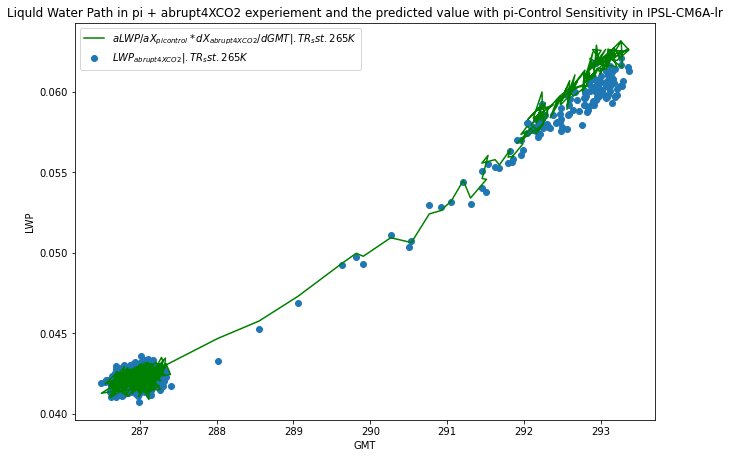

In [32]:
#..abrupt+piC Plot:



fig2  = plt.figure(figsize = (10.4, 7.3))
ax2  = plt.axes()

plt.scatter(GMT, LWP_area_yr_whole, label='$LWP_{abrupt4XCO2} |.TR_sst.265K$')

#print(np.array(GMT).shape)

plt.plot(GMT, LWP_pre, "g", label='$aLWP/aX_{picontrol}*{dX_{abrupt4XCO2}/dGMT}|.TR_sst.265K$')
#plt.ylim((0.105, 0.121))
273.15

plt.xlabel('GMT')
plt.ylabel('LWP')
plt.title("Liquld Water Path in pi + abrupt4XCO2 experiement and the predicted value with pi-Control Sensitivity in IPSL-CM6A-lr")

plt.legend()

plt.savefig("Linear_Regression_IPSL-CM6A-LR_abrupt_bin model_ seventh(gengzheng)_265K_ overyrs_.png")



In [33]:
#..abrupt+piC Plot (real-mean):

'''

fig3  = plt.figure(figsize = (10.4, 7.3))
ax3  = plt.axes()

plt.scatter(GMT, LWP_meanarea_yr_whole, label='$LWP_{abrupt4XCO2} |.TR_sst.270.0K$')

print(np.array(Yrs).shape)

plt.plot(GMT, LWP_meanpre, "g", label='$aLWP/aX_{picontrol}*{dX_{abrupt4XCO2}/dGMT}|.TR_sst.270.0K$')


plt.xlabel('GMT')
plt.ylabel('LWP')
plt.title("Real-Mean: Liquid Water Path in pi+ abrupt4XCO2 experiement with the predicted value in IPSL-CM6A-LR")  #..!!


plt.legend()

#plt.savefig("Linear_Regression_IPSLabrupt_bin model_ fifthth Merge Regresion270K.png")
'''



'\n\nfig3  = plt.figure(figsize = (10.4, 7.3))\nax3  = plt.axes()\n\nplt.scatter(GMT, LWP_meanarea_yr_whole, label=\'$LWP_{abrupt4XCO2} |.TR_sst.270.0K$\')\n\nprint(np.array(Yrs).shape)\n\nplt.plot(GMT, LWP_meanpre, "g", label=\'$aLWP/aX_{picontrol}*{dX_{abrupt4XCO2}/dGMT}|.TR_sst.270.0K$\')\n\n\nplt.xlabel(\'GMT\')\nplt.ylabel(\'LWP\')\nplt.title("Real-Mean: Liquid Water Path in pi+ abrupt4XCO2 experiement with the predicted value in IPSL-CM6A-LR")  #..!!\n\n\nplt.legend()\n\n#plt.savefig("Linear_Regression_IPSLabrupt_bin model_ fifthth Merge Regresion270K.png")\n'

In [34]:
np.array(dX_dTg).reshape(-1,1)

dLWP_DTg  = np.dot(aeffi.reshape(1,-1), np.array(dX_dTg).reshape(-1,1) )
print(dLWP_DTg)

[[0.00335421]]


In [35]:
def binned_skewTamnW(XX,  YY,  S, lat_Y, lon_X):
    '''
    Calculate the binned array for the mean value of LWP over T_skew-Wvp bidimensional axes
    '''

    #XX, YY  = np.meshgrid(lon_X, lat_Y, indexing='xy')
    #..split Tskew as N1 parts, Wvp as N2 parts ..
    #x_range  = np.arange(0., 364, 5.)   #..number:73
    #y_range  = np.arange(-90., 90, 5.)   #..(37)
    
    xbins, ybins = len(lon_X)-1, len(lat_Y)-1
    
    S_binned_array  = np.zeros((S.shape[0], ybins, xbins))   #..Take as output
    
    for i in np.arange(S.shape[0]):
        
        XX_time_step  = XX[i,:,:]
        YY_time_step  = YY[i,:,:]
        S_time_step  = S[i,:,:]

        
        #..find and subtract the missing points
        ind =  np.isnan(S[i,:,:]* XX[i,:,:]* YY[i,:,:])== False  #..Ind_true
        S_binned_time , xedge, yedge, binnumber  = stats.binned_statistic_2d(XX_time_step[ind].ravel(),YY_time_step[ind].ravel(), values = S_time_step[ind].ravel(),
                                                                            statistic ='mean', bins=[lon_X, lat_Y], expand_binnumbers =True)
        
        S_binned_array[i,:,:] = S_binned_time.T
    
    return S_binned_array



In [36]:
pro_yr = LWP_yr * SST_yr * PRW_yr


ind_nan_e = np.isnan(pro_yr.flatten())==True
ind_flase_e =  np.array(np.nonzero(ind_nan_e ==True))
print(ind_flase_e.shape)

A = [0.12, np.nan, 3.2,0.46, -1.6, np.nan]
B = [np.nan, 0.2,  3.4, np.nan, np.nan, -1.2]
c = np.array([[0.12, np.nan, 3.2, 0.46, -1.6, np.nan], [np.nan, 0.2,  3.4, np.nan, np.nan, -1.2]])
print(c)
np.nanmean(c, axis=1)


(1, 0)
[[ 0.12   nan  3.2   0.46 -1.6    nan]
 [  nan  0.2   3.4    nan   nan -1.2 ]]


array([0.545, 0.8  ])

(1800, 12, 25)
(12, 25)
(1, 187)
AxesSubplot(0.125,0.125;0.775x0.755)


/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()


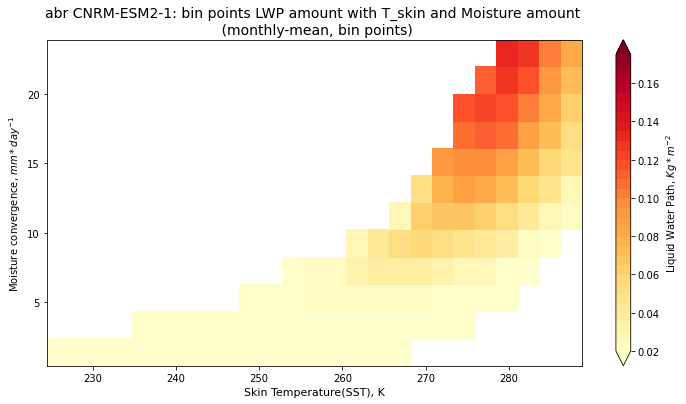

In [56]:
#plt.figure(figsize=(9,6))

#..y and x are SST and water vapor path at some points, Perspectively
#y, x = np.mgrid[slice(0., 80. + dy, dy), slice(240.,290.+ dx, dx)]
y = np.linspace(np.nanpercentile(PRW_mon_bin_abr, 5), np.nanpercentile(PRW_mon_bin_abr, 95), 13)
#print(y)
#print(np.linspace(np.nanpercentile(SST_predi, 5), np.nanpercentile(SST_predi, 96), 50))
x = np.linspace(np.nanpercentile(SST_mon_bin_abr, 5), np.nanpercentile(SST_mon_bin_abr, 95), 26)
#print(x.shape, y.shape)


LWP_bin_Tskew_wvp =  binned_skewTamnW(SST_mon_bin_abr, PRW_mon_bin_abr, LWP_mon_bin_abr, y, x)

print(LWP_bin_Tskew_wvp.shape)

anmean_LWP_bin_Tskew_wvp  = np.nanmean(LWP_bin_Tskew_wvp, axis=0)
print(anmean_LWP_bin_Tskew_wvp.shape)

ind_nan = np.isnan(anmean_LWP_bin_Tskew_wvp.flatten())==True
ind_flase =  np.array(np.nonzero(ind_nan==True))
print(ind_flase.shape)

#print(np.linspace(np.nanpercentile(SST_bin_pred_abr, 5), np.nanpercentile(SST_bin_pred_abr, 96), 50))
'''
LWP_pi = np.zeros((161, 51))
LWP_abr  = np.zeros((161,51))

for i in np.arange(161):
    for j in np.arange(57):
        
        if SST_predi >= (240.+j*1.0) and SST_predi < (240.+(j+1)*1.0) and PRW_predi > (0.+ 0.5*i) and PRW_predi < (0+ 0.5 *(i+1)) :
'''        

## begins for plotting Pcolormesh 

X, Y  = np.meshgrid(x, y)
#print(X.shape, Y.shape, anmean_LWP_bin_Tskew_wvp.shape)

#..defined a proper LWP ticks within its range

levels = np.arange(0.02, 0.18, 0.005)

#..pick the desired colormap
cmap = plt.get_cmap('YlOrRd')

norm = BoundaryNorm(levels, ncolors= cmap.N, extend='both')



#.. what will the pcolormesh plot looks like?
fig,ax  = plt.subplots(figsize =(12,6))

print(ax)

im  = ax.pcolormesh(x, y, anmean_LWP_bin_Tskew_wvp, cmap=cmap, norm= norm)
ax.set_title('abr CNRM-ESM2-1: bin points LWP amount with T_skin and Moisture amount \n (monthly-mean, bin points)', fontsize = 14)
ax.set_xlabel('Skin Temperature(SST), K', fontsize=11)
#ax.set_ylabel('Water Vapor Path, ' + r'$Kg*m^{-2}$', fontsize=10)

ax.set_ylabel('Moisture convergence, ' + r'$mm*day^{-1}$')
fig.colorbar(im, ax= ax, label="Liquid Water Path, " + r"$Kg*m^{-2}}$")


#plt.savefig('pcolor-CNRM-ESM2-1 _ LWP_Tskew_ WVP_ abr| monbin.png')

(25, 12)
(1, 216)
(13, 26) (13, 26) (12, 25)
AxesSubplot(0.125,0.125;0.775x0.755)


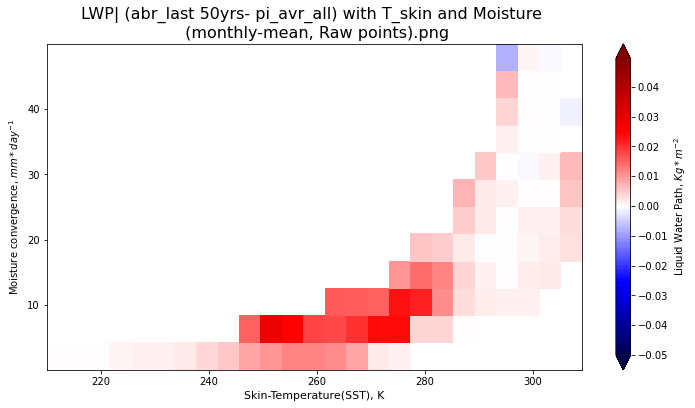

In [83]:
#plt.figure(figsize=(9,6))   #.. Try to use: LWP|abr_(last 50 years) - pi(99 yrs average) with Tskew\ Water Vapor Path

PRW_abr_last50 =  np.nanmean(prw_abr[-50:,:,:], axis=0)
LWP_abr_last50 =  np.nanmean(LWP_abr[-50:,:,:], axis=0)
SST_abr_last50 =  np.nanmean(SST_abr[-50:,:,:], axis=0)
p_e_abr_last50 =  np.nanmean(MC_abr[-50:,:,:], axis=0)
#print(SST_abr_last50)


PRW_pi_aver   =   np.nanmean(prw_pi[:,:,:], axis=0)
#print(PRW_pi_aver.shape)
LWP_pi_aver   =   np.nanmean(LWP[:,:,:], axis=0)
SST_pi_aver   =   np.nanmean(SST[:,:,:], axis=0)
p_e_pi_aver   =   np.nanmean(MC[:,:,:], axis=0)

diff_LWP =  LWP_abr_last50 -LWP_pi_aver
diff_SST =  SST_abr_last50 - SST_pi_aver

diff_PRW =  PRW_abr_last50 - PRW_pi_aver

#..y and x are SST and Water vapor path at some points, Perspectively
y = np.linspace(np.nanpercentile(PRW_pi_aver, 0), np.nanpercentile(PRW_pi_aver, 100), 13)
#print(y)
#print(np.linspace(np.nanpercentile(SST_predi, 5), np.nanpercentile(SST_predi, 96), 50))
x = np.linspace(np.nanpercentile(SST_pi_aver, 0), np.nanpercentile(SST_pi_aver, 100), 26)
#print(x.shape, y.shape)




LWP_bin_Tskew_wvp, xedge, yedge, binnumber  = stats.binned_statistic_2d(SST_pi_aver.ravel(), PRW_pi_aver.ravel(), values = diff_LWP.ravel(),
                                                                           statistic ='mean', bins=[x, y], expand_binnumbers =True)
print(LWP_bin_Tskew_wvp.shape)
LWP_bin_Tskew_wvp  = LWP_bin_Tskew_wvp.T

ind_nan = np.isnan(LWP_bin_Tskew_wvp.flatten())==True
ind_flase =  np.array(np.nonzero(ind_nan==True))
print(ind_flase.shape)



## begins for plotting Pcolormesh

X, Y  = np.meshgrid(x, y)
print(X.shape, Y.shape, anmean_LWP_bin_Tskew_wvp.shape)

#..defined a proper LWP ticks within its range

levels = np.arange(-0.050, 0.050, 0.0005)

#..pick the desired colormap
cmap = plt.get_cmap('seismic')

norm = BoundaryNorm(levels, ncolors= cmap.N, extend='both')


#.. what will the pcolormesh plot looks like?
fig,ax  = plt.subplots(figsize =(12,6))

print(ax)

im  = ax.pcolormesh(x, y, LWP_bin_Tskew_wvp[:, :], cmap=cmap, norm= norm)
ax.set_title('LWP| (abr_last 50yrs- pi_avr_all) with T_skin and Moisture \n (monthly-mean, Raw points).png', fontsize = 16)
ax.set_xlabel('Skin-Temperature(SST), K', fontsize=11)
#ax.set_ylabel('Water Vapor Path, ' + r'$Kg*m^{-2}$', fontsize=10)

ax.set_ylabel('Moisture convergence, ' + r'$mm*day^{-1}$')
fig.colorbar(im, ax= ax, label="Liquid Water Path, " + r"$Kg*m^{-2}}$")


#plt.savefig('pcolor-CNRM-ESM2-1: LWP_abr(last50)-pi_ Tskew(pi)_ WVP(pi).png')

